In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import v2

c:\Users\Pawel\anaconda3\envs\env_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = './knee-osteoarthritis'

In [3]:
TRAIN_PATH = f'{DATASET_PATH}/train'
VAL_PATH = f'{DATASET_PATH}/val'
TEST_PATH = f'{DATASET_PATH}/test'
AUTO_TEST_PATH = f'{DATASET_PATH}/auto_test'

In [4]:
transform_toTensor = transforms.Compose([transforms.ToTensor()])

In [5]:
train = torchvision.datasets.ImageFolder(TRAIN_PATH, transform_toTensor)
val = torchvision.datasets.ImageFolder(VAL_PATH, transform_toTensor)
# test = torchvision.datasets.ImageFolder(TEST_PATH, transform_toTensor)
# auto_test = torchvision.datasets.ImageFolder(AUTO_TEST_PATH, transform_toTensor)

In [6]:
print(len(train))
print(len(val))
# print(len(test))
# print(len(auto_test))

5778
826


### Augmentation 

In [7]:
import cv2
import numpy as np

#### Edges

In [8]:
sobel_y_1 = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
])
sobel_y_2 = sobel_y_1 * -1

def getAugmentationEdges(image):
    grayscaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply two filters, upper and lower for different bones
    edges_1 = cv2.filter2D(grayscaled, -1, sobel_y_1)
    edges_2 = cv2.filter2D(grayscaled, -1, sobel_y_2)

    # Cutout noisy background 
    _, edges_1 = cv2.threshold(edges_1, 10, 255, cv2.THRESH_TOZERO)
    _, edges_2 = cv2.threshold(edges_2, 10, 255, cv2.THRESH_TOZERO)

    edges = edges_1 + edges_2

    max_brightness = edges.max()

    # Normalize color
    edges = cv2.convertScaleAbs(edges, alpha = 255/max_brightness, beta = 0)

    return edges

### Building Dataset

In [9]:
example_img = train[0][0]
# print(example_img)
print(example_img.shape)

torch.Size([3, 224, 224])


In [10]:
transform_baseImage = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(256),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
])

transform_edgesImage = v2.Compose([
    v2.ToDtype(torch.float),
    # v2.Resize(256),
    # v2.CenterCrop(256),
    v2.Normalize(mean=[0.449], std=[0.226])
])

In [11]:

from torch.utils.data import Dataset, DataLoader

class KneeOsteoarthritis(Dataset):
    def __init__(self, dataset):
        self.images = []
        self.edges_images = []
        self.labels = []
        
        for data in dataset:
            image = data[0]
            image_agmentation = image.numpy()*255
            image_agmentation = np.moveaxis(image_agmentation, 0, -1)
            edges_image = getAugmentationEdges(image_agmentation)
            # print(image.shape, image_agmentation.shape, edges_image.shape)
            edges_image = torch.tensor(edges_image)
            label = data[1]
            
            image = transform_baseImage(image)
            # print(image.shape, edges_image.shape)
            edges_image = transform_edgesImage(edges_image.unsqueeze(0))
            
            self.images.append(image)
            self.edges_images.append(edges_image)            
            self.labels.append(label)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        edges_image = self.edges_images[idx]
        label = self.labels[idx]
        
        return image, edges_image, label

In [12]:
train_dataset = KneeOsteoarthritis(train)
val_dataset = KneeOsteoarthritis(val)
# test_dataset = KneeOsteoarthritis(test)
# auto_test_dataset = KneeOsteoarthritis(auto_test)

c:\Users\Pawel\anaconda3\envs\env_torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 224, 224])


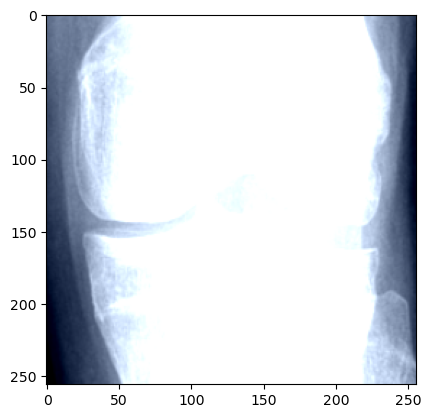

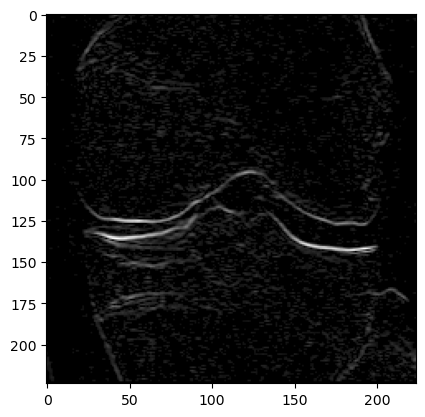

In [14]:
row = train_dataset[1]
normal_ex = row[0]
augmented_ex = row[1]
print(normal_ex.shape, augmented_ex.shape)


imshow(normal_ex)
imshow(augmented_ex)

### Configuring loader

In [15]:
from collections import Counter

In [16]:

def get_Class_Frequency(dataset):
  freq_table = dict(Counter(dataset.labels))
  return freq_table

def build_Sampler(dataset):
  freq_table = get_Class_Frequency(dataset)
  least_class_frequency = min(freq_table.values())

  normalized_freq = dict(freq_table)
  for i, val in enumerate(normalized_freq.values()):
    normalized_freq[i] = val / len(dataset.labels)
    
  print(normalized_freq, least_class_frequency)
  
  weights = np.zeros(len(dataset.labels))
  for i, weight in enumerate(weights):
    label = dataset.labels[i]
    weights[i] = 1 / freq_table[label]
      
  # print(weights)
  samples_weight = torch.from_numpy(weights)
  samples_weigth = samples_weight.double()
  sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))
  
  return sampler

In [17]:
train_sampler = build_Sampler(train_dataset)
val_sampler = build_Sampler(val_dataset)

{0: 0.3956386292834891, 1: 0.5744202146071304, 2: 0.029941156109380408} 173
{0: 0.39709443099273606, 1: 0.5702179176755447, 2: 0.03268765133171913} 27


In [18]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, sampler=val_sampler)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

### Building Model

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [20]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18, ResNet18_Weights

class AugmentedModel(nn.Module):
    def __init__(self, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()
        
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights, progress=False)
        
        self.edgesClassifier = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Dropout(p=dropout*0.4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout*0.8),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(32 * 6 * 6, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(64, num_classes),
            # nn.ReLU(inplace=True),
            # nn.Linear(64, num_classes),
        )
        
        self.baseClassifier = nn.Sequential(
            # nn.Dropout(p=dropout),
            nn.Linear(1000, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
        
        self.outputCombiner = nn.Sequential(
            nn.Linear(2 * num_classes, num_classes),
        )

    def forward(self, image: torch.Tensor, edges: torch.Tensor) -> torch.Tensor:
        
        # out_edges = self.edgesClassifier(edges)
        # # print(out_edges.shape)
        # return out_edges
        out_edges = self.edgesClassifier(edges)
      
        out_image = self.resnet18(image)
        out_image = self.baseClassifier(out_image)
        
        concated = torch.cat((out_image, out_edges), 1)
        
        res = self.outputCombiner(concated)
        return res
      
net = AugmentedModel(3, 0.5)
net = net.to(device)

### Freeze Resnet

In [21]:
for param in net.resnet18.parameters():
    param.requires_grad = False

In [22]:
# print(sum(p.numel() for p in net.classifier.parameters()) ,sum(p.numel() for p in net.edgesClassifier.parameters()) )
print(sum(p.numel() for p in net.parameters()))

trainable_parameters = filter(lambda p: p.requires_grad, net.parameters())
print(sum(p.numel() for p in trainable_parameters))

12189859
500347


### Setting up Model Training

In [23]:
import torch.optim as optim
# criterion = nn.NLLLoss()

class_weights = get_Class_Frequency(train_dataset)
weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
print(weights_tensor, weights_tensor.dtype)

criterion = nn.CrossEntropyLoss(weights_tensor)
optimizer = optim.Adam(net.parameters(), lr=0.001)

tensor([2286., 3319.,  173.], device='cuda:0') torch.float32


In [24]:
def validate(model):
  with torch.no_grad():
    epoch_correct = 0
    epoch_samples = 0
    running_loss = 0.0
    
    for i, data in enumerate(val_loader):
      images, edges, labels = data
      images = images.to(device)
      edges = edges.to(device)
      labels = labels.to(device)
      
      # forward + backward + optimize
      outputs = model(images, edges)
      loss = criterion(outputs, labels)
      
      # Changing outputs (logits) to labels
      outputs_clear = outputs.max(1).indices
      
      epoch_correct += (outputs_clear == labels).float().sum()
      epoch_samples += len(outputs)
      
      running_loss += loss.item()
    
    # print(epoch_correct, epoch_samples)
    accuracy = epoch_correct / epoch_samples * 100
    
    return accuracy, running_loss / epoch_samples
    

In [25]:
def train_many(model, start_epoch, epochs_nr, regularization_type = "L2", lambda_reg=0.01):
   
    for epoch in range(start_epoch, start_epoch + epochs_nr):  # loop over the dataset multiple times
        
        epoch_correct = 0
        epoch_samples = 0
        running_loss = 0.0
    
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            images, edges, labels = data
            images = images.to(device)
            edges = edges.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(images, edges)
            loss = criterion(outputs, labels)
            
            # Apply L1 regularization
            if regularization_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * l1_norm
                
            # Apply L2 regularization
            elif regularization_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm
                
            loss.backward()
            
            optimizer.step()
            
            # Changing outputs (logits) to labels
            outputs_clear = outputs.max(1).indices
            
            epoch_correct += (outputs_clear == labels).float().sum()
            epoch_samples += len(outputs)
            
            running_loss += loss.item()
                
        accuracy = epoch_correct / epoch_samples * 100
        
        # Validation
        vAccuracy, vLoss = validate(model)
        
        print(f'Epoch {epoch + 1}: Training: accuracy: {accuracy:.3f}%, loss: {running_loss / epoch_samples:.3f}; Validation: accuracy: {vAccuracy:.3f}%, loss: {vLoss:.3f}')
                

    print('Finished Training')

### Training Model

In [26]:
train_many(net, 0, 25, 'L2', 0.01)

Epoch 1: Training: accuracy: 57.165%, loss: 6.191; Validation: accuracy: 57.143%, loss: 0.041
Epoch 2: Training: accuracy: 58.100%, loss: 6.158; Validation: accuracy: 56.780%, loss: 0.041
Epoch 3: Training: accuracy: 58.827%, loss: 6.147; Validation: accuracy: 57.506%, loss: 0.040
Epoch 4: Training: accuracy: 59.882%, loss: 6.140; Validation: accuracy: 57.143%, loss: 0.040
Epoch 5: Training: accuracy: 59.588%, loss: 6.137; Validation: accuracy: 60.169%, loss: 0.039
Epoch 6: Training: accuracy: 59.796%, loss: 6.134; Validation: accuracy: 57.506%, loss: 0.039
Epoch 7: Training: accuracy: 60.367%, loss: 6.133; Validation: accuracy: 59.806%, loss: 0.040
Epoch 8: Training: accuracy: 60.748%, loss: 6.132; Validation: accuracy: 59.927%, loss: 0.039
Epoch 9: Training: accuracy: 61.457%, loss: 6.131; Validation: accuracy: 58.232%, loss: 0.038
Epoch 10: Training: accuracy: 62.167%, loss: 6.131; Validation: accuracy: 59.564%, loss: 0.038
Epoch 11: Training: accuracy: 62.444%, loss: 6.130; Validat

In [27]:
train_many(net, 25, 50, 'L2', 0.005)

Epoch 26: Training: accuracy: 66.269%, loss: 3.082; Validation: accuracy: 61.985%, loss: 0.038
Epoch 27: Training: accuracy: 65.732%, loss: 3.082; Validation: accuracy: 62.228%, loss: 0.038
Epoch 28: Training: accuracy: 64.521%, loss: 3.083; Validation: accuracy: 62.470%, loss: 0.037
Epoch 29: Training: accuracy: 66.424%, loss: 3.083; Validation: accuracy: 62.228%, loss: 0.038
Epoch 30: Training: accuracy: 65.940%, loss: 3.083; Validation: accuracy: 64.407%, loss: 0.037
Epoch 31: Training: accuracy: 66.182%, loss: 3.082; Validation: accuracy: 64.649%, loss: 0.038
Epoch 32: Training: accuracy: 66.528%, loss: 3.083; Validation: accuracy: 64.407%, loss: 0.037
Epoch 33: Training: accuracy: 66.372%, loss: 3.083; Validation: accuracy: 65.012%, loss: 0.036
Epoch 34: Training: accuracy: 65.697%, loss: 3.083; Validation: accuracy: 64.165%, loss: 0.037
Epoch 35: Training: accuracy: 67.169%, loss: 3.083; Validation: accuracy: 61.017%, loss: 0.037
Epoch 36: Training: accuracy: 67.151%, loss: 3.083

In [28]:
train_many(net, 50, 200, 'L2', 0.0025)

Epoch 51: Training: accuracy: 68.605%, loss: 1.558; Validation: accuracy: 63.923%, loss: 0.036
Epoch 52: Training: accuracy: 69.592%, loss: 1.558; Validation: accuracy: 65.617%, loss: 0.037
Epoch 53: Training: accuracy: 70.042%, loss: 1.558; Validation: accuracy: 66.223%, loss: 0.037
Epoch 54: Training: accuracy: 70.232%, loss: 1.558; Validation: accuracy: 64.770%, loss: 0.036
Epoch 55: Training: accuracy: 69.868%, loss: 1.558; Validation: accuracy: 64.649%, loss: 0.035
Epoch 56: Training: accuracy: 69.903%, loss: 1.558; Validation: accuracy: 62.470%, loss: 0.037
Epoch 57: Training: accuracy: 69.695%, loss: 1.558; Validation: accuracy: 65.496%, loss: 0.036
Epoch 58: Training: accuracy: 70.007%, loss: 1.558; Validation: accuracy: 68.281%, loss: 0.037
Epoch 59: Training: accuracy: 70.734%, loss: 1.558; Validation: accuracy: 65.254%, loss: 0.039
Epoch 60: Training: accuracy: 71.426%, loss: 1.558; Validation: accuracy: 67.433%, loss: 0.037


KeyboardInterrupt: 